In [1]:
!pip install rdkit-pypi
!pip install mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 38.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 46.4 MB/s eta 0:00:00a 0:00:01
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176720 sha256=e7d021df022ff566cde311d4996a1309dfbbd2847053c651fca8f49dd17123bf
  Stored in directory: /home/PAK-CSPMZ/aseikin/.cache/pip/wheels/8b/30/0b/84e3f6775306e74cf5957ee4d16b10bf3927dcec44cc23d5f2
Successfully built mordred
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3


In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import SaltRemover

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import rdFMCS
import pandas as pd
import numpy as np

import pandas as pd
from sklearn.cluster import DBSCAN
from rdkit import Chem
from rdkit.Chem import rdFMCS

from tqdm import tqdm
from rdkit import RDLogger

# Отключение всех логов ниже уровня критических ошибок (чтобы РДКит не спамил ошибки при препроцессинге)
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# Изменить путь в соотвествии со средой выполнения
# train_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/admet/admet/admet-prediction/train_admet.csv')
# train_dataset = pd.read_csv('admet-prediction/train_admet.csv')
test_dataset = pd.read_csv('data/test_data.csv')

In [6]:
# train_dataset
test_dataset

,Unnamed: 0,Drug_ID,Drug,property
0,0,0,Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3,1
1,1,1,CN(CC(O)CO)N=O,1
2,2,2,O=[N+]([O-])c1ccc(OC2CO2)cc1,1
3,3,3,Cn1cnc2cc([N+](=O)[O-])ccc21,1
4,4,4,CC[C@H](CO)NCCN[C@H](CC)CO,1
...,...,...,...,...
1216,1216,1216,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...,3
1217,1217,1217,O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2[C@H]1CN1CCCC1,3
1218,1218,1218,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,3
1219,1219,1219,Cn1nc(-c2cccc(F)c2)n(C)c1=S,3


In [7]:
# Объявляем функцию 'fixing_substructures' которая принимает на вход объект 'mol'
# Задача функции -- исправление различных химических подструктур
def fixing_substructures(mol):

    #1 sulfone: проверяем, содержит ли молекула подструктуру '[S+:1](=[O:2])[O-1:3]' и заменяем ее на 'rxn'
    while mol.HasSubstructMatch(Chem.MolFromSmarts('[S+:1](=[O:2])[O-1:3]')):
        rxn = '[S+1:1](=[O:2])[O-1:3]>>[S+0:1](=[O+0:2])=[O+0:3]'
        # Используем метод ReactionFromSmarts, который преобразует строковое представление р-ции SMARTS в объект RDKit
        rxn_rdkit = Chem.rdChemReactions.ReactionFromSmarts(rxn)
        # Метод RunReactants возвращает список возможных продуктов р-ции, результат заменяет исходную молекулу
        mol = rxn_rdkit.RunReactants((mol, ))[0][0]

    #2 aromatic N-Oxide: поиск подструктуры '[c:1]1[c:2](=[N:3])[n+:4](=[O:5])[cH-:6][nH:7][c:8]1' и замена на 'rxn'
    while mol.HasSubstructMatch(Chem.MolFromSmarts('[c:1]1[c:2](=[N:3])[n+:4](=[O:5])[cH-:6][nH:7][c:8]1')):
        rxn = '[c:1]1[c:2](=[N:3])[n+:4](=[O:5])[cH-:6][nH:7][c:8]1>>[c:1]1[c:2]([N:3])=[n+1:4]([O-1:5])[cH:6]=[n:7][c:8]1'
        rxn_rdkit = Chem.rdChemReactions.ReactionFromSmarts(rxn)
        mol = rxn_rdkit.RunReactants((mol, ))[0][0]

    #3.1 Ninto c-: Обработка структур, сод. нитрогруппу
    while mol.HasSubstructMatch(Chem.MolFromSmarts('[C-H2][N+]([O-])=O')):
        rxn = '[C-H2:1][N+:2]([O-:3])=[O:4]>>[CH3+0:1][N+:2]([O-:3])=[O:4]'
        rxn_rdkit = Chem.rdChemReactions.ReactionFromSmarts(rxn)
        mol = rxn_rdkit.RunReactants((mol, ))[0][0]

    #3.2 Ninto c-: аналогичная обработка, но для подструктур с одной связью водорода
    while mol.HasSubstructMatch(Chem.MolFromSmarts('[C-H1][N+]([O-])=O')):
        rxn = '[C-H1:1][N+:2]([O-:3])=[O:4]>>[CH2+0:1][N+:2]([O-:3])=[O:4]'
        rxn_rdkit = Chem.rdChemReactions.ReactionFromSmarts(rxn)
        mol = rxn_rdkit.RunReactants((mol, ))[0][0]

    #3.3 Ninto c-: аналогичная обработка, но для варианта с нулевой связью водорода
    while mol.HasSubstructMatch(Chem.MolFromSmarts('[C-H0][N+]([O-])=O')):
        rxn = '[C-H0:1][N+:2]([O-:3])=[O:4]>>[CH1+0:1][N+:2]([O-:3])=[O:4]'
        rxn_rdkit = Chem.rdChemReactions.ReactionFromSmarts(rxn)
        mol = rxn_rdkit.RunReactants((mol, ))[0][0]

    #4 =Nitro: замена нитрогруппы
    while mol.HasSubstructMatch(Chem.MolFromSmarts('C=[N+]([O-])O')):
        rxn = '[C:1]=[N+:2]([O-:3])[O:4]>>[C:1]-[N+:2]([O-:3])=[O:4]'
        rxn_rdkit = Chem.rdChemReactions.ReactionFromSmarts(rxn)
        mol = rxn_rdkit.RunReactants((mol, ))[0][0]

    #5 pyrrol: преобразование пиролла 'C1=CC=NC1' в его ароматическую форму с атомом азота
    while mol.HasSubstructMatch(Chem.MolFromSmarts('C1=CC=NC1')):
        rxn = '[C:1]1=[C:2][C:3]=[N:4][C:5]1>>[c:1]1[c:2][c:3][nH:4][c:5]1'
        rxn_rdkit = Chem.rdChemReactions.ReactionFromSmarts(rxn)
        mol = rxn_rdkit.RunReactants((mol, ))[0][0]

    return mol

# Объявляем ф-цию 'neutralize_atoms', которая нейтрализирует заряды на атомах
def neutralize_atoms(mol):
  # Создаем паттерн SMARTS для поиска атомов с зарядами, которые необходимо нейтрализовать.
  # Паттерн ищет атомы с положительным зарядом (+1), которые не содержат связей с отрицательно заряженными атомами (-1) и наоборот
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches] # создаем список индексов атомов, которые совпали с паттерном
    if len(at_matches_list) > 0: # проверяем совпадения с паттерном
        for at_idx in at_matches_list: # цикл проходит по каждому совпавшему атому, используя его индекс
            atom = mol.GetAtomWithIdx(at_idx) # получаем атом по индексу
            # извлекаем формальный формальный заряд атома и кол-во атомов водорода, связанных с ним
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            # устанавливаем формальный заряд атома 0 -- нейтрализуем заряд, корректируем кол-во атомов водорода в соот. с изменением заряда
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            # обвновляем св-ва атома в молекуле после внесенных изменений
            atom.UpdatePropertyCache()
    return mol


In [9]:
# Создаем объект 'remover' с помощью класса 'SaltRemover' из библ. RDKit кот. отвечает за удаление солей из молекул
# remover = SaltRemover.SaltRemover(defnFilename='Salts.txt') # измените путь на необходимый
remover = SaltRemover.SaltRemover(defnFilename='data/Salts.txt') # измените путь на необходимый
canonical_smiles = [] # Создаем пустой список, куда будут сохраняться канонические SMILES

# Цикл, который проходит по всем значениям колонки 'Drug' в нашем датасете 'train_dataset'
for smiles in test_dataset.Drug.values:
  # Ф-ция 'Chem.MolFromSmiles(smiles)' преобразует строковое представление молекулы в объект RDkit
  # Chem.AddHs добавляет молекуле атомы водорода, если их не хватает
  # Chem.RemoveHs удаляет неявные атомы водорода, чтобы оставить только важные
  # Цель на данном этапе -- убедиться, что молекула полноценно содержит все необходимые атомы
    mol = Chem.RemoveHs(Chem.AddHs(Chem.MolFromSmiles(smiles)))
    res_mol = remover.StripMol(mol, dontRemoveEverything=True)
    # приводим молекулы в стандартную форму
    res_mol = Chem.RemoveHs(Chem.AddHs(neutralize_atoms(res_mol)))
    res_mol = fixing_substructures(res_mol)
    # этот шаг важен для стандартизации молекулы в ее каноническую форму
    res_mol = Chem.MolFromSmiles(Chem.MolToSmiles(res_mol))

    if res_mol:
      # молекула конвертируется в SMILES с исп. Chem.MolToSmiles. Опция isomericSmiles=False указывает на то, что информация о стереохимии не будет сохраняться в смайлсах
        canon_smiles = Chem.MolToSmiles(res_mol, isomericSmiles=False)
        # точка в смайлсах указывает на наличиее нескольких отдельных молекул/фрагментах в одном представлении.
        if '.' in canon_smiles:
            if all(x == canon_smiles.split('.')[0] for x in canon_smiles.split('.')): # если после удаления солевой части осталось несколько равных частей
                canonical_smiles.append(canon_smiles.split('.')[0])
            else: #если элементы разные
                canonical_smiles.append('')
        else:
            canonical_smiles.append(canon_smiles)
    else:
        canonical_smiles.append('')


In [ ]:
canonical_smiles

['O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2',
 'O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4ccccc4c(=O)c3c3[nH]c4c(ccc5c(=O)c6ccccc6c(=O)c54)c3c12',
 '[N-]=[N+]=CC(=O)NCC(=O)NN',
 '[N-]=[N+]=C1C=NC(=O)NC1=O',
 'CCCCN(CC(O)C1=CC(=[N+]=[N-])C(=O)C=C1)N=O',
 '[N-]=[N+]=CC(=O)OCC(N)C(=O)O',
 'CC(=O)OC1(C(C)=O)CCC2C3C=C(Cl)C4=CC(=O)OCC4(C)C3CCC21C',
 'Nc1nc(N)nc(N)n1',
 'Cc1ccc(N=Nc2c(O)ccc3ccccc23)c([N+](=O)[O-])c1',
 'CC(C)CC(=O)Nc1snc2ccccc12',
 'Cc1cccc([N+](=O)[O-])c1C',
 'CCC[N+](=O)[O-]',
 'O=C(O)c1cc([N+](=O)[O-])cc2cccnc12',
 'NC(=O)Nc1nc2ccccc2[nH]1',
 'Nc1ccc2c(c1)oc1ccccc12',
 'Cc1ccc2ccc3ccc(C)cc3c2c1',
 'Cc1cc2c(nc(N)n2C)c2ncc(-c3ccccc3)nc12',
 'NNc1nnc(NN)c2ccccc12',
 'C=CC(=O)NCNC(=O)C=C',
 'OCc1cc2c3c(cccc3c1)-c1ccccc1-2',
 'Cc1cc(O)c2c(c1)C(=O)C13C4C(=O)C56C(=O)c7c(O)cc(C)cc7C(=O)C57C(C(=O)C16C2=O)C(C)C3C7C4C',
 'Cc1nc(N)nc(N)n1',
 'CCNc1nc(N)nc(Cl)n1',
 'CC(=O)NC(CSC(Cl)=C(Cl)Cl)C(=O)O',
 'CC1CCC2C(C)CCC(C(C)C)C2C1',
 'CCN=NNCC',
 'O=[N+]([O-])c1ccc2c(c1)-c1cccc3cccc-2c1

In [10]:
# train_dataset['canonical_smiles'] = canonical_smiles
test_dataset['canonical_smiles'] = canonical_smiles

In [11]:
# train_dataset
test_dataset

,Unnamed: 0,Drug_ID,Drug,property,canonical_smiles
0,0,0,Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3,1,Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3
1,1,1,CN(CC(O)CO)N=O,1,CN(CC(O)CO)N=O
2,2,2,O=[N+]([O-])c1ccc(OC2CO2)cc1,1,O=[N+]([O-])c1ccc(OC2CO2)cc1
3,3,3,Cn1cnc2cc([N+](=O)[O-])ccc21,1,Cn1cnc2cc([N+](=O)[O-])ccc21
4,4,4,CC[C@H](CO)NCCN[C@H](CC)CO,1,CCC(CO)NCCNC(CC)CO
...,...,...,...,...,...
1216,1216,1216,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...,3,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...
1217,1217,1217,O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2[C@H]1CN1CCCC1,3,O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2C1CN1CCCC1
1218,1218,1218,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,3,CN1CCC23c4c5ccc(O)c4OC2C(=O)CCC3C1C5
1219,1219,1219,Cn1nc(-c2cccc(F)c2)n(C)c1=S,3,Cn1nc(-c2cccc(F)c2)n(C)c1=S


In [13]:
# Получаем уникальные значения в столбце 'property'
unique_properties = test_dataset['property'].unique()

# Для каждого уникального значения 'property' создаем отдельную таблицу
for prop in unique_properties:

    # Фильтруем данные по текущему значению property
    df_filtered = test_dataset[test_dataset['property'] == prop]

    # Удаляем строки, где canonical_smiles пуст
    df_filtered = df_filtered[df_filtered['canonical_smiles'].notna()]

    # Удаляем дубликаты по столбцу 'canonical_smiles'
    df_filtered = df_filtered.drop_duplicates(subset='canonical_smiles')


    # Сохраняем каждую таблицу в отдельный CSV файл (путь измените)
    # file_name = f"preprocessed/{prop}_prop_train.csv"
    file_name = f"data/preprocessed/{prop}_prop_train.csv"
    df_filtered.to_csv(file_name, index=False)



Сейчас в папке preprocessed лежат почти готовые датасеты под каждое свойство, там есть канонический смайлс, смайлсы починены, стереохимия удалена, удалена солевая часть (там где можно ее однозначно идентифицировать), удалены дубликаты и смеси (было 3 штуки смесей).
Однако, в этих датасетах есть очень похожие молекулярные структуры (отличаются 1-2-3 атомами), теоритически, это может повлиять на обучение. Поэтому, молекулы можно кластеризовать при необходимости, используя, например классическую метрику симилярити по Танимото (функция для ее подсчета для двух смайлсов приведена ниже).

Однако, необходимо отметить, что эта функция очень прожорливая и часто критикуется хемоинформатическим сообществом за не адекватность оценки в некоторых случаях. Тем не менее, считаю, что для подобных датасетов эта метрика схожести подходит.

In [14]:
# Объявляем ф-цию для расчета Танимото-симилярити между двумя молекулами на основе их максимальной общей подструктуры (MCS)
# принимает на вход список смайлсов 'sm_list', где ожидается две молекулы, между кот. будет расчитываться коэф. Танимото
def calc_tanimoto_similarity(sm_list):
    m1 = Chem.MolFromSmiles(sm_list[0])
    m2 = Chem.MolFromSmiles(sm_list[1])
    ms = [m1, m2]
# изпользуется ф-ция FindMCS из рдкита для поиска MCS. 'ringMatchesRingOnly=True' -- сопостовляются только кольца ('completeRingsOnly=False' -- части колец тоже могут совпадать)
    MCS = rdFMCS.FindMCS(ms, ringMatchesRingOnly=True, completeRingsOnly=False)
    num_atoms_MCS = MCS.numAtoms # извлекаем кол-во атомов

    # рассчитываем коэф. Танимото на сонове числа тяжелых атомов в обеих молекулах
    tanimoto_similarity = num_atoms_MCS/(m1.GetNumHeavyAtoms() + m2.GetNumHeavyAtoms() - num_atoms_MCS)*100
    return tanimoto_similarity

Tanimoto similarity =  80.0


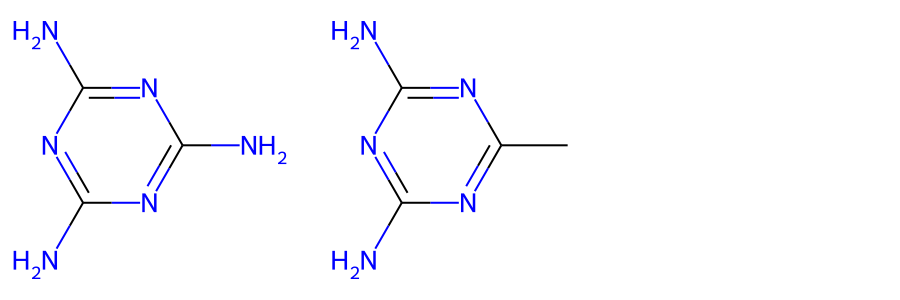

In [15]:
# пример
sm = ['Nc1nc(N)nc(N)n1',
      'Cc1nc(N)nc(N)n1']

print('Tanimoto similarity = ', calc_tanimoto_similarity(sm))
mol1 = Chem.MolFromSmiles(sm[0])
mol2 = Chem.MolFromSmiles(sm[1])



img1 = Chem.Draw.MolsToGridImage([mol1, mol2], subImgSize=(300, 300))
display(img1)


Tanimoto similarity =  77.77777777777779


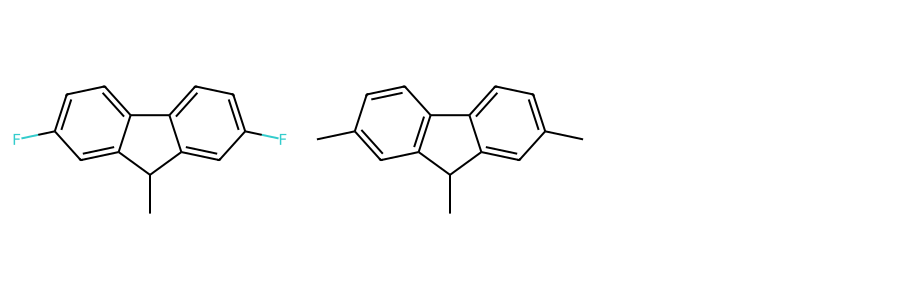

In [16]:
# пример
sm = ['CC1c2cc(F)ccc2-c2ccc(F)cc21',
      'CC1c(cc(C)cc2)c2-c2c1cc(C)cc2']

print('Tanimoto similarity = ', calc_tanimoto_similarity(sm))
mol1 = Chem.MolFromSmiles(sm[0])
mol2 = Chem.MolFromSmiles(sm[1])



img1 = Chem.Draw.MolsToGridImage([mol1, mol2], subImgSize=(300, 300))
display(img1)


Tanimoto similarity =  100.0


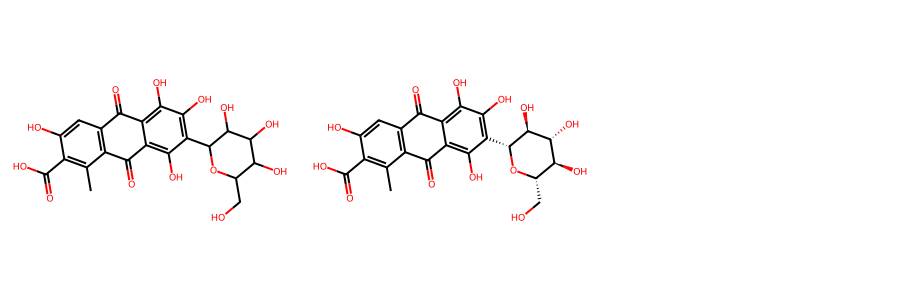

In [17]:
# пример
sm = ['Cc1c(C(=O)O)c(O)cc2c1C(=O)c1c(O)c(C3OC(CO)C(O)C(O)C3O)c(O)c(O)c1C2=O',
      'Cc1c(C(=O)O)c(O)cc2c1C(=O)c1c(O)c([C@H]3O[C@@H](CO)[C@H](O)[C@@H](O)[C@@H]3O)c(O)c(O)c1C2=O']

print('Tanimoto similarity = ', calc_tanimoto_similarity(sm))
mol1 = Chem.MolFromSmiles(sm[0])
mol2 = Chem.MolFromSmiles(sm[1])



img1 = Chem.Draw.MolsToGridImage([mol1, mol2], subImgSize=(300, 300))
display(img1)


Последний пример может показывать еще одну возможную уязвимость -- в датасете пристуствуют разные оптические изомеры и рацематы. Возможно, на этапе препроцессинга следует удалить информацию связанную со стереохимией, и после этого одна структура из таких пар удалится как дубликат.

Это легко сделать, модифицировав 1 строчку

In [18]:
canon_smiles = Chem.MolToSmiles(res_mol) # было
canon_smiles = Chem.MolToSmiles(res_mol, isomericSmiles=False) # стало

В подготовленных датасетах стереохимия удалена. Для данной задачи она не играет особой роли, а моделькам будет попроще.

удаление дубликатов и пустых строк из train_dataset

In [19]:
test_dataset_cleaned = test_dataset.drop_duplicates(subset=['canonical_smiles', 'property'])
final_count = len(test_dataset_cleaned)
test_dataset_cleaned['canonical_smiles'].replace('', np.nan, inplace=True)
test_dataset_cleaned = test_dataset_cleaned.dropna(subset='canonical_smiles')
test_dataset_cleaned = test_dataset_cleaned.reset_index(drop=True)
nan_count = len(test_dataset_cleaned)
# Количество строк после удаления дубликатов
initial_count = len(test_dataset)

# Количество удалённых дубликатов
removed_duplicates = initial_count - final_count

print(f"Было удалено {removed_duplicates} дубликатов")
print(f"Было удалено {final_count-nan_count} nan")

Было удалено 4 дубликатов
Было удалено 2 nan


/tmp/ipykernel_2168041/1414323899.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_dataset_cleaned['canonical_smiles'].replace('', np.nan, inplace=True)
/tmp/ipykernel_2168041/1414323899.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset_cleaned['canonical_smiles'].replace('', np.nan, inplace=True)


In [20]:
test_dataset_cleaned

,Unnamed: 0,Drug_ID,Drug,property,canonical_smiles
0,0,0,Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3,1,Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3
1,1,1,CN(CC(O)CO)N=O,1,CN(CC(O)CO)N=O
2,2,2,O=[N+]([O-])c1ccc(OC2CO2)cc1,1,O=[N+]([O-])c1ccc(OC2CO2)cc1
3,3,3,Cn1cnc2cc([N+](=O)[O-])ccc21,1,Cn1cnc2cc([N+](=O)[O-])ccc21
4,4,4,CC[C@H](CO)NCCN[C@H](CC)CO,1,CCC(CO)NCCNC(CC)CO
...,...,...,...,...,...
1210,1216,1216,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...,3,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...
1211,1217,1217,O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2[C@H]1CN1CCCC1,3,O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2C1CN1CCCC1
1212,1218,1218,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,3,CN1CCC23c4c5ccc(O)c4OC2C(=O)CCC3C1C5
1213,1219,1219,Cn1nc(-c2cccc(F)c2)n(C)c1=S,3,Cn1nc(-c2cccc(F)c2)n(C)c1=S


In [21]:
from rdkit.Chem import Descriptors

# функция для подсчета рдкит дескрипторов

def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule

        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res


In [23]:
# дескрипторы считаются с молекул -- надо конвертировать смайлс строки в молекулы
test_mols = [Chem.MolFromSmiles(x) for x in test_dataset_cleaned.canonical_smiles.values]

In [24]:
# подсчет дескрипторов
test_mols_rdkit_desc = [getMolDescriptors(m) for m in tqdm(test_mols)]

100%|██████████| 1215/1215 [00:08<00:00, 135.32it/s]


In [25]:
# сохранение дескрипторов в отдельную таблицу
test_mols_rdkit_desc_df = pd.DataFrame(test_mols_rdkit_desc)
test_mols_rdkit_desc_df

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.453287,-0.827190,11.453287,0.358743,0.537391,260.245,248.149,260.068473,98,0,...,0,0,0,0,0,0,0,0,0,0
1,9.639436,-0.881759,9.639436,0.069444,0.379944,134.135,124.055,134.069142,54,0,...,0,0,0,0,0,0,0,0,0,0
2,10.286822,-0.447020,10.286822,0.059320,0.400523,181.147,174.091,181.037508,68,0,...,0,0,0,0,0,0,0,0,0,0
3,10.422392,-0.422500,10.422392,0.075185,0.489245,177.163,170.107,177.053826,66,0,...,0,0,0,0,0,0,0,0,0,0
4,8.903975,0.188201,8.903975,0.188201,0.389671,204.314,180.122,204.183778,86,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,14.444280,-2.020949,14.444280,0.057387,0.177970,810.938,752.474,810.393890,318,0,...,0,0,0,0,0,0,0,0,0,0
1211,13.114333,0.165159,13.114333,0.165159,0.723098,409.382,387.206,408.082990,138,0,...,0,0,0,0,0,0,0,1,0,0
1212,12.492664,-0.365926,12.492664,0.172454,0.786934,285.343,266.191,285.136493,110,0,...,0,0,0,0,0,0,0,0,0,0
1213,13.021997,-0.274008,13.021997,0.274008,0.692187,223.276,213.196,223.057947,78,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# генератор фингерпринтов

def get_morgan_fingerprint(mol, radius=2, nBits=1024):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)

fingerprints = [get_morgan_fingerprint(mol) for mol in tqdm(test_mols)]

# Преобразование фингерпринтов в массив numpy
fingerprint_array = np.array([list(fp) for fp in fingerprints])

# Создание pandas DataFrame
df_fingerprints = pd.DataFrame(fingerprint_array, columns=[f'bit_{i}' for i in range(fingerprint_array.shape[1])])

100%|██████████| 1215/1215 [00:00<00:00, 24047.53it/s]


In [27]:
# отдельная таблица фингерпринтов
df_fingerprints

,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,bit_7,bit_8,bit_9,...,bit_1014,bit_1015,bit_1016,bit_1017,bit_1018,bit_1019,bit_1020,bit_1021,bit_1022,bit_1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,0,0,0,0,0,0,0,0,1,0,...,0,1,0,1,0,1,0,1,0,0
1211,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1212,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
from mordred import Calculator, descriptors

# подсчет мордред дескрипторов и сохраниение в отдельную таблицу
calc = Calculator(descriptors, ignore_3D=True)

df_mordred = calc.pandas(test_mols)


 19%|█▉        | 236/1215 [00:01<00:05, 164.92it/s]

/home/PAK-CSPMZ/aseikin/anaconda3/envs/admet/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 62%|██████▏   | 759/1215 [00:05<00:04, 108.48it/s]

/home/PAK-CSPMZ/aseikin/anaconda3/envs/admet/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1215/1215 [00:08<00:00, 136.85it/s]


/home/PAK-CSPMZ/aseikin/anaconda3/envs/admet/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [29]:
df_mordred

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,24.456993,2.693924,5.254569,24.456993,1.287210,3.954704,...,10.670001,69.686364,260.068473,8.389306,587,37,118.0,152.0,6.541667,3.798611
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,10.290762,2.074313,4.148627,10.290762,1.143418,3.018430,...,8.069968,35.817252,134.069142,7.056271,100,8,34.0,34.0,4.972222,2.333333
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,16.681306,2.323861,4.582926,16.681306,1.283177,3.538369,...,9.280706,62.301165,181.037508,9.051875,269,15,66.0,75.0,4.194444,2.861111
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,16.526787,2.414639,4.723851,16.526787,1.271291,3.507417,...,9.461021,58.468612,177.053826,8.852691,235,18,68.0,80.0,4.805556,2.833333
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,2,17.000791,2.091184,4.182367,17.000791,1.214342,3.461869,...,8.532476,43.099321,204.183778,5.373257,383,15,54.0,56.0,6.222222,3.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,71.866114,2.630442,5.183926,71.866114,1.239071,4.967657,...,11.086793,111.779282,810.393890,6.986154,13328,112,302.0,364.0,25.368056,12.944444
1211,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,34.073606,2.466903,4.879856,34.073606,1.310523,4.204611,...,10.180703,76.504715,408.082990,8.501729,1668,39,140.0,166.0,7.500000,5.638889
1212,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,28.425851,2.706557,5.324692,28.425851,1.353612,4.057008,...,10.691286,71.524431,285.136493,7.128412,712,49,132.0,173.0,6.062500,4.291667
1213,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,18.929400,2.430965,4.725308,18.929400,1.261960,3.641457,...,9.597166,61.453916,223.057947,8.922318,350,22,78.0,92.0,5.916667,3.277778


нужно будет дропнуть первые два столбца

In [30]:
# дропаем два столбца, которые почему то не посчитались
df_mordred = df_mordred.drop(['ABC', 'ABCGG'], axis=1)
df_mordred

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,0,24.456993,2.693924,5.254569,24.456993,1.287210,3.954704,3.753518,0.197554,...,10.670001,69.686364,260.068473,8.389306,587,37,118.0,152.0,6.541667,3.798611
1,0,0,10.290762,2.074313,4.148627,10.290762,1.143418,3.018430,2.770783,0.307865,...,8.069968,35.817252,134.069142,7.056271,100,8,34.0,34.0,4.972222,2.333333
2,0,0,16.681306,2.323861,4.582926,16.681306,1.283177,3.538369,3.391539,0.260888,...,9.280706,62.301165,181.037508,9.051875,269,15,66.0,75.0,4.194444,2.861111
3,0,0,16.526787,2.414639,4.723851,16.526787,1.271291,3.507417,3.326678,0.255898,...,9.461021,58.468612,177.053826,8.852691,235,18,68.0,80.0,4.805556,2.833333
4,0,2,17.000791,2.091184,4.182367,17.000791,1.214342,3.461869,3.487200,0.249086,...,8.532476,43.099321,204.183778,5.373257,383,15,54.0,56.0,6.222222,3.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,0,0,71.866114,2.630442,5.183926,71.866114,1.239071,4.967657,4.573659,0.078856,...,11.086793,111.779282,810.393890,6.986154,13328,112,302.0,364.0,25.368056,12.944444
1211,0,1,34.073606,2.466903,4.879856,34.073606,1.310523,4.204611,4.184415,0.160939,...,10.180703,76.504715,408.082990,8.501729,1668,39,140.0,166.0,7.500000,5.638889
1212,0,1,28.425851,2.706557,5.324692,28.425851,1.353612,4.057008,4.114951,0.195950,...,10.691286,71.524431,285.136493,7.128412,712,49,132.0,173.0,6.062500,4.291667
1213,0,0,18.929400,2.430965,4.725308,18.929400,1.261960,3.641457,3.489524,0.232635,...,9.597166,61.453916,223.057947,8.922318,350,22,78.0,92.0,5.916667,3.277778


In [31]:
# объединение всех фичей, включая fingerprints, дескрипторы RDKit, и Mordred
df_all_features = pd.concat([test_dataset_cleaned, df_fingerprints, test_mols_rdkit_desc_df, df_mordred], axis=1)
df_all_features

,Unnamed: 0,Drug_ID,Drug,property,canonical_smiles,bit_0,bit_1,bit_2,bit_3,bit_4,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,0,0,Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3,1,Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3,0,0,0,0,0,...,10.670001,69.686364,260.068473,8.389306,587,37,118.0,152.0,6.541667,3.798611
1,1,1,CN(CC(O)CO)N=O,1,CN(CC(O)CO)N=O,0,1,0,0,0,...,8.069968,35.817252,134.069142,7.056271,100,8,34.0,34.0,4.972222,2.333333
2,2,2,O=[N+]([O-])c1ccc(OC2CO2)cc1,1,O=[N+]([O-])c1ccc(OC2CO2)cc1,0,0,0,0,0,...,9.280706,62.301165,181.037508,9.051875,269,15,66.0,75.0,4.194444,2.861111
3,3,3,Cn1cnc2cc([N+](=O)[O-])ccc21,1,Cn1cnc2cc([N+](=O)[O-])ccc21,0,0,0,0,0,...,9.461021,58.468612,177.053826,8.852691,235,18,68.0,80.0,4.805556,2.833333
4,4,4,CC[C@H](CO)NCCN[C@H](CC)CO,1,CCC(CO)NCCNC(CC)CO,0,1,0,0,0,...,8.532476,43.099321,204.183778,5.373257,383,15,54.0,56.0,6.222222,3.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,1216,1216,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...,3,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...,0,0,0,0,0,...,11.086793,111.779282,810.393890,6.986154,13328,112,302.0,364.0,25.368056,12.944444
1211,1217,1217,O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2[C@H]1CN1CCCC1,3,O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2C1CN1CCCC1,0,0,0,1,1,...,10.180703,76.504715,408.082990,8.501729,1668,39,140.0,166.0,7.500000,5.638889
1212,1218,1218,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,3,CN1CCC23c4c5ccc(O)c4OC2C(=O)CCC3C1C5,0,0,0,0,0,...,10.691286,71.524431,285.136493,7.128412,712,49,132.0,173.0,6.062500,4.291667
1213,1219,1219,Cn1nc(-c2cccc(F)c2)n(C)c1=S,3,Cn1nc(-c2cccc(F)c2)n(C)c1=S,0,0,0,0,0,...,9.597166,61.453916,223.057947,8.922318,350,22,78.0,92.0,5.916667,3.277778


In [33]:
# Удаляем все столбцы, которые не являются числовыми
df_numeric = df_all_features.select_dtypes(include=[np.number])

# Порог для корреляции
correlation_threshold = 0.9

# Рассчитываем матрицу корреляции только для числовых данных
correlation_matrix = df_numeric.corr().abs()

# Выбираем фичи с корреляцией выше порога
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Находим фичи с корреляцией выше порога
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

# Удаляем высококоррелированные фичи из исходного DataFrame
test_all_features_cleaned = df_all_features.drop(columns=to_drop)

# Выводим информацию о том, сколько фичей было удалено
print(f'Удалено {len(to_drop)} фичей с корреляцией выше {correlation_threshold}')

# Сохраняем финальные данные в файл
test_all_features_cleaned.to_csv('data/test_features_cleaned.csv', index=False)


Удалено 781 фичей с корреляцией выше 0.9


In [34]:
test_all_features_cleaned

,Unnamed: 0,Drug,canonical_smiles,bit_0,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,...,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,JGT10,TopoShapeIndex,Vabc,SRW05
0,0,Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3,Cc1cc(=O)oc2ccc3c(c12)C1(C)OOC1(C)O3,0,0,0,0,0,0,0,...,0.030470,0.031905,0.024453,0.010204,0.000000,0.000000,0.629189,1.000000,210.243256,2.397895
1,1,CN(CC(O)CO)N=O,CN(CC(O)CO)N=O,0,1,0,0,0,0,0,...,0.013889,0.000000,0.000000,0.000000,0.000000,0.000000,0.527654,1.000000,123.468143,0.000000
2,2,O=[N+]([O-])c1ccc(OC2CO2)cc1,O=[N+]([O-])c1ccc(OC2CO2)cc1,0,0,0,0,0,0,0,...,0.036493,0.021215,0.021046,0.015625,0.000000,0.000000,0.473341,1.000000,146.923255,3.713572
3,3,Cn1cnc2cc([N+](=O)[O-])ccc21,Cn1cnc2cc([N+](=O)[O-])ccc21,0,0,0,0,0,0,0,...,0.050595,0.038549,0.000000,0.000000,0.000000,0.000000,0.512133,0.750000,137.799864,2.397895
4,4,CC[C@H](CO)NCCN[C@H](CC)CO,CCC(CO)NCCNC(CC)CO,0,1,0,0,0,0,0,...,0.012346,0.020408,0.015625,0.012346,0.000000,0.000000,0.394064,0.800000,221.090286,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,1216,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...,CCN(CC)C(=O)COc1cc2c(O)c3c(O)c(C)c4c(c13)C(=O)...,0,0,0,0,0,0,0,...,0.031118,0.021479,0.015946,0.013170,0.011152,0.008126,0.546423,0.583333,781.886952,2.397895
1211,1217,O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2[C@H]1CN1CCCC1,O=C(Cc1ccc(Cl)c(Cl)c1)N1CCc2sccc2C1CN1CCCC1,0,0,0,1,1,0,0,...,0.022883,0.013617,0.011556,0.009155,0.007917,0.009625,0.407030,1.000000,347.146483,3.044522
1212,1218,CN1CC[C@]23c4c5ccc(O)c4O[C@H]2C(=O)CC[C@H]3[C@...,CN1CCC23c4c5ccc(O)c4OC2C(=O)CCC3C1C5,0,0,0,0,0,0,0,...,0.031236,0.026309,0.028935,0.000000,0.000000,0.000000,0.499350,1.000000,256.727519,2.397895
1213,1219,Cn1nc(-c2cccc(F)c2)n(C)c1=S,Cn1nc(-c2cccc(F)c2)n(C)c1=S,0,0,0,0,0,0,0,...,0.030278,0.027519,0.013889,0.000000,0.000000,0.000000,0.511063,0.750000,179.387964,2.397895
